# Implement Bayesian Optimization from Scratch in Python

Hyperparameter optimization is a challenging problem of finding an input that results in the minimum or maximum cost of a given objective function.

Bayesian Optimization provides a principled technique based on Bayes Theorem to direct a search of a global optimization problem that is efficient and effective. It works by building a probabilistic model of the objective function, called the surrogate function, that is then searched efficiently with an acquisition function before candidate samples are chosen for evaluation on the real objective function.

Bayesian Optimization is often used in applied machine learning to tune the hyperparameters of a given well-performing model on a validation dataset.

## What is bayesian optimization

Bayesian Optimization is an approach that uses Bayes Theorem to direct the search in order to find the minimum or maximum of an objective function.

It is an approach that is most useful for objective functions that are complex, noisy, and/or expensive to evaluate.

Recall that Bayes Theorem is an approach for calculating the conditional probability of an event:

$$P(A|B) = \frac{P(B|A) * P(A)}{P(B)}$$

We can simplify this calculation by removing the normalizing value of P(B) and describe the conditional probability as a proportional quantity. This is useful as we are not interested in calculating a specific conditional probability, but instead in optimizing a quantity.

$$P(A|B) = P(B|A) * P(A)$$

The conditional probability that we are calculating is referred to generally as the posterior probability; the reverse conditional probability is sometimes referred to as the likelihood, and the marginal probability is referred to as the prior probability; for example:

$$posterior = likelihood * prior$$
This provides a framework that can be used to quantify the beliefs about an unknown objective function given samples from the domain and their evaluation via the objective function.

We can devise specific samples $(x_1, x_2, …, x_n)$ and evaluate them using the objective function f(xi) that returns the cost or outcome for the sample xi. Samples and their outcome are collected sequentially and define our data D, e.g. $D = {x_i, f(x_i), … x_n, f(x_n)}$ and is used to define the prior. The likelihood function is defined as the probability of observing the data given the function $P(D | f)$. This likelihood function will change as more observations are collected.

$$P(f|D) = P(D|f) * P(f)$$
The posterior represents everything we know about the objective function. It is an approximation of the objective function and can be used to estimate the cost of different candidate samples that we may want to evaluate.

In this way, the posterior probability is a surrogate objective function.

- **Surrogate Function**: Bayesian approximation of the objective function that can be sampled efficiently.
The surrogate function gives us an estimate of the objective function, which can be used to direct future sampling. Sampling involves careful use of the posterior in a function known as the “acquisition” function, e.g. for acquiring more samples. We want to use our belief about the objective function to sample the area of the search space that is most likely to pay off, therefore the acquisition will optimize the conditional probability of locations in the search to generate the next sample.

- **Acquisition Function**: Technique by which the posterior is used to select the next sample from the search space.
Once additional samples and their evaluation via the objective function f() have been collected, they are added to data D and the posterior is then updated.

This process is repeated until the extrema of the objective function is located, a good enough result is located, or resources are exhausted.

The Bayesian Optimization algorithm can be summarized as follows:

1. Select a Sample by Optimizing the Acquisition Function.
2. Evaluate the Sample With the Objective Function.
3. Update the Data and, in turn, the Surrogate Function.
4. Go To 1.

## Performing Bayesian Optimization

In this section, we will explore how Bayesian Optimization works by developing an implementation from scratch for a simple one-dimensional test function.

First, we will define the test problem, then how to model the mapping of inputs to outputs with a surrogate function. Next, we will see how the surrogate function can be searched efficiently with an acquisition function before tying all of these elements together into the Bayesian Optimization procedure.

In [1]:
import numpy as np
import math
from matplotlib import pyplot

### Problem definition

We will use a multimodal problem with five peaks, calculated as:

$$y = x^2 * sin(5 * \pi * x)^6$$


Where x is a real value in the range $[0,1]$.

We will augment this function by adding Gaussian noise with a mean of zero and a standard deviation of 0.1. This will mean that the real evaluation will have a positive or negative random value added to it, making the function challenging to optimize.

The objective() function below implements this.

In [2]:
# objective function
def objective(x, noise=0.1):
    noise = np.random.normal(loc=0, scale=noise)
    return (x**2 * math.sin(5 * math.pi * x)**6.0) + noise

We can test this function by first defining a grid-based sample of inputs from 0 to 1 with a step size of 0.01 across the domain.

In [3]:
# grid-based sample of the domain [0,1]
X = np.arange(0, 1, 0.01)

We can then evaluate these samples using the target function without any noise to see what the real objective function looks like.

In [4]:
# sample the domain without noise
y = [objective(x, 0) for x in X]

We can then evaluate these same points with noise to see what the objective function will look like when we are optimizing it.

In [5]:
# sample the domain with noise
ynoise = [objective(x) for x in X]

We can look at all of the non-noisy objective function values to find the input that resulted in the best score and report it. This will be the optima, in this case, maxima, as we are maximizing the output of the objective function.

We would not know this in practice, but for out test problem, it is good to know the real best input and output of the function to see if the Bayesian Optimization algorithm can locate it.

In [6]:
# find best result
ix = np.argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

Optima: x=0.900, y=0.810


Finally, we can create a plot, first showing the noisy evaluation as a scatter plot with input on the x-axis and score on the y-axis, then a line plot of the scores without any noise.

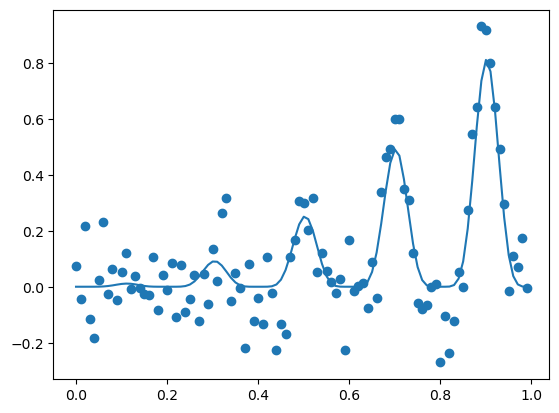

In [7]:
# plot the points with noise
pyplot.scatter(X, ynoise)
# plot the points without noise
pyplot.plot(X, y)
# show the plot
pyplot.show()

### Surrogate Function

The surrogate function is a technique used to best approximate the mapping of input examples to an output score.

Probabilistically, it summarizes the conditional probability of an objective function $(f)$, given the available data $(D)$ or $P(f|D)$.

A number of techniques can be used for this, although the most popular is to treat the problem as a regression predictive modeling problem with the data representing the input and the score representing the output to the model. This is often best modeled using a random forest or a Gaussian Process.

A Gaussian Process, or GP, is a model that constructs a joint probability distribution over the variables, assuming a multivariate Gaussian distribution. As such, it is capable of efficient and effective summarization of a large number of functions and smooth transition as more observations are made available to the model.

This smooth structure and smooth transition to new functions based on data are desirable properties as we sample the domain, and the multivariate Gaussian basis to the model means that an estimate from the model will be a mean of a distribution with a standard deviation; that will be helpful later in the acquisition function.

As such, using a GP regression model is often preferred.

We can fit a GP regression model using the GaussianProcessRegressor scikit-learn implementation from a sample of inputs $(X)$ and noisy evaluations from the objective function $(y)$.

First, the model must be defined. An important aspect in defining the GP model is the kernel. This controls the shape of the function at specific points based on distance measures between actual data observations. Many different kernel functions can be used, and some may offer better performance for specific datasets.

By default, a Radial Basis Function, or RBF, is used that can work well.



In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

Once defined, the model can be fit on the training dataset directly by calling the fit() function.

The defined model can be fit again at any time with updated data concatenated to the existing data by another call to fit().

The model will estimate the cost for one or more samples provided to it.

The model is used by calling the predict() function. The result for a given sample will be a mean of the distribution at that point. We can also get the standard deviation of the distribution at that point in the function by specifying the argument return_std=True; for example:

This function can result in warnings if the distribution is thin at a given point we are interested in sampling.

Therefore, we can silence all of the warnings when making a prediction. The surrogate() function below takes the fit model and one or more samples and returns the mean and standard deviation estimated costs whilst not printing any warnings.

In [29]:
from warnings import catch_warnings
from warnings import simplefilter
# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

We can call this function any time to estimate the cost of one or more samples, such as when we want to optimize the acquisition function in the next section.

For now, it is interesting to see what the surrogate function looks like across the domain after it is trained on a random sample.

We can achieve this by first fitting the GP model on a random sample of 100 data points and their real objective function values with noise. We can then plot a scatter plot of these points. Next, we can perform a grid-based sample across the input domain and estimate the cost at each point using the surrogate function and plot the result as a line.

We would expect the surrogate function to have a crude approximation of the true non-noisy objective function.

The plot() function below creates this plot, given the random data sample of the real noisy objective function and the fit model.

In [30]:
# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = np.asarray(np.arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()

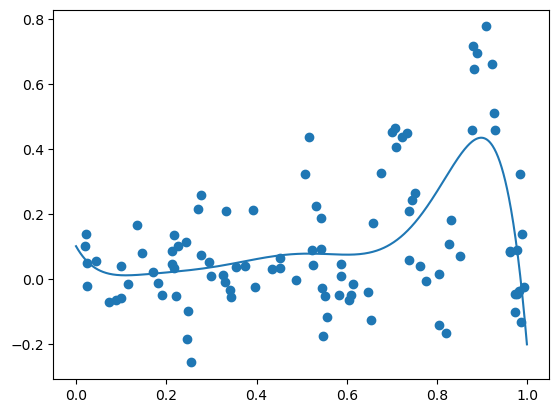

In [31]:
# sample the domain sparsely with noise
X = np.random.random(100)
y = np.asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function
plot(X, y, model)

Running the example first draws the random sample, evaluates it with the noisy objective function, then fits the GP model.

The data sample and a grid of points across the domain evaluated via the surrogate function are then plotted as dots and a line respectively.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

In this case, as we expected, the plot resembles a crude version of the underlying non-noisy objective function, importantly with a peak around 0.9 where we know the true maxima is located.

### Acquisition Function
The surrogate function is used to test a range of candidate samples in the domain.

From these results, one or more candidates can be selected and evaluated with the real, and in normal practice, computationally expensive cost function.

This involves two pieces: the search strategy used to navigate the domain in response to the surrogate function and the acquisition function that is used to interpret and score the response from the surrogate function.

A simple search strategy, such as a random sample or grid-based sample, can be used, although it is more common to use a local search strategy, such as the popular BFGS algorithm. In this case, we will use a random search or random sample of the domain in order to keep the example simple.

This involves first drawing a random sample of candidate samples from the domain, evaluating them with the acquisition function, then maximizing the acquisition function or choosing the candidate sample that gives the best score. The opt_acquisition() function below implements this.

In [32]:
# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = np.random.random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = np.argmax(scores)
	return Xsamples[ix, 0]

The acquisition function is responsible for scoring or estimating the likelihood that a given candidate sample (input) is worth evaluating with the real objective function.

We could just use the surrogate score directly. Alternately, given that we have chosen a Gaussian Process model as the surrogate function, we can use the probabilistic information from this model in the acquisition function to calculate the probability that a given sample is worth evaluating.

There are many different types of probabilistic acquisition functions that can be used, each providing a different trade-off for how exploitative (greedy) and explorative they are.

Three common examples include:

Probability of Improvement (PI).
Expected Improvement (EI).
Lower Confidence Bound (LCB).
The Probability of Improvement method is the simplest, whereas the Expected Improvement method is the most commonly used.

In this case, we will use the simpler Probability of Improvement method, which is calculated as the normal cumulative probability of the normalized expected improvement, calculated as follows:

$$PI = cdf\left(\frac{\mu – best_\mu}{stdev}\right)$$
Where PI is the probability of improvement, cdf() is the normal cumulative distribution function, mu is the mean of the surrogate function for a given sample x, stdev is the standard deviation of the surrogate function for a given sample x, and best_mu is the mean of the surrogate function for the best sample found so far.

We can add a very small number to the standard deviation to avoid a divide by zero error.

The acquisition() function below implements this given the current training dataset of input samples, an array of new candidate samples, and the fit GP model.



In [35]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[0]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

### Complete Bayesian Optimization Algorithm
We can tie all of this together into the Bayesian Optimization algorithm.

The main algorithm involves cycles of selecting candidate samples, evaluating them with the objective function, then updating the GP model.

In [36]:
# perform the optimization process
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding for our own reporting
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)

>x=0.867, f()=0.409685, actual=0.324
>x=0.537, f()=0.078321, actual=0.430
>x=0.775, f()=0.213021, actual=-0.148
>x=0.327, f()=0.042126, actual=0.116
>x=0.159, f()=0.016356, actual=-0.087
>x=0.551, f()=0.095848, actual=0.075
>x=0.086, f()=0.009375, actual=0.150
>x=0.436, f()=0.088535, actual=-0.087
>x=0.570, f()=0.088965, actual=0.141
>x=0.150, f()=0.019856, actual=0.008
>x=0.932, f()=0.384418, actual=0.324
>x=0.231, f()=0.019849, actual=0.028
>x=0.598, f()=0.086385, actual=0.050
>x=0.749, f()=0.149954, actual=0.025
>x=0.118, f()=0.020449, actual=-0.093
>x=0.979, f()=0.069796, actual=0.124
>x=0.539, f()=0.092772, actual=-0.009
>x=0.352, f()=0.048283, actual=0.066
>x=0.492, f()=0.089502, actual=0.322
>x=0.050, f()=0.032407, actual=0.018
>x=0.406, f()=0.077116, actual=-0.035
>x=0.198, f()=0.014165, actual=0.076
>x=0.973, f()=0.140369, actual=0.049
>x=0.982, f()=0.039765, actual=0.092
>x=0.581, f()=0.088017, actual=-0.012
>x=0.138, f()=0.013041, actual=-0.005
>x=0.040, f()=0.037950, actual

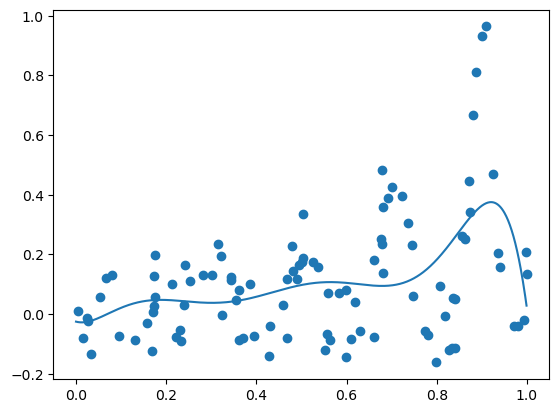

>x=0.371, f()=0.048242, actual=0.118
>x=0.692, f()=0.094449, actual=0.383
>x=0.250, f()=0.044871, actual=-0.148
>x=0.744, f()=0.127684, actual=0.188
>x=0.563, f()=0.114644, actual=-0.024
>x=0.314, f()=0.033376, actual=0.029
>x=0.232, f()=0.037701, actual=0.129
>x=0.787, f()=0.175522, actual=-0.108
>x=0.395, f()=0.052938, actual=-0.102
>x=0.214, f()=0.044185, actual=0.076
>x=0.703, f()=0.102439, actual=0.385
>x=0.958, f()=0.308438, actual=0.071
>x=0.091, f()=0.013448, actual=-0.142
>x=0.919, f()=0.344996, actual=0.845
>x=0.598, f()=0.114033, actual=-0.059
>x=0.435, f()=0.060990, actual=-0.060
>x=0.181, f()=0.043449, actual=0.094
>x=0.008, f()=-0.019307, actual=-0.140
>x=0.193, f()=0.048859, actual=-0.025
>x=0.834, f()=0.257072, actual=0.046
>x=0.883, f()=0.342671, actual=0.558
>x=0.953, f()=0.345582, actual=0.034
>x=0.793, f()=0.183636, actual=0.048
>x=0.033, f()=-0.046321, actual=-0.003
>x=0.434, f()=0.057473, actual=-0.031
>x=0.351, f()=0.027249, actual=0.074
>x=0.275, f()=0.033243, a

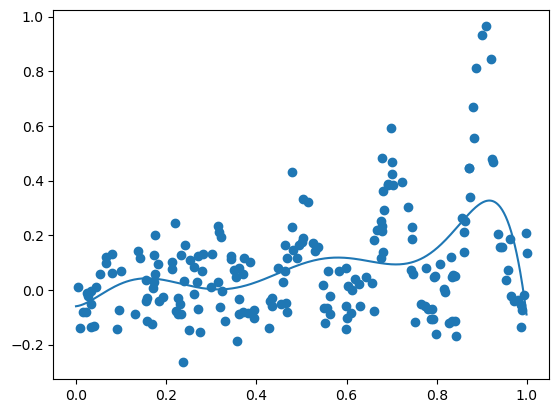

Best Result: x=0.909, y=0.964


In [37]:
# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

# objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[0]
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

## Hyperparameter Tuning With Bayesian Optimization

It can be a useful exercise to implement Bayesian Optimization to learn how it works.

In practice, when using Bayesian Optimization on a project, it is a good idea to use a standard implementation provided in an open-source library. This is to both avoid bugs and to leverage a wider range of configuration options and speed improvements.

Two popular libraries for Bayesian Optimization include Scikit-Optimize and HyperOpt. In machine learning, these libraries are often used to tune the hyperparameters of algorithms.

Hyperparameter tuning is a good fit for Bayesian Optimization because the evaluation function is computationally expensive (e.g. training models for each set of hyperparameters) and noisy (e.g. noise in training data and stochastic learning algorithms).

In this section, we will take a brief look at how to use the Scikit-Optimize library to optimize the hyperparameters of a k-nearest neighbor classifier for a simple test classification problem. This will provide a useful template that you can use on your own projects.

The Scikit-Optimize project is designed to provide access to Bayesian Optimization for applications that use SciPy and NumPy, or applications that use scikit-learn machine learning algorithms.

In [39]:
!pip install scikit-optimize

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.2 MB/s eta 0:00:00


In [40]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2)
# define the model
model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	# something
	model.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = mean(result)
	return 1.0 - estimate

# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

/Users/junxiaoguo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/junxiaoguo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/junxiaoguo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/junxiaoguo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/junxiaoguo/opt/anaconda3/envs/ml/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserW

Best Accuracy: 0.974
Best Parameters: n_neighbors=5, p=1


Running the example executes the hyperparameter tuning using Bayesian Optimization.